# Movie Recommendations using Collaborative Filtering with Surprise


## Project Scope

The objective is to demonstrate the build of a simple movie recommendation system using Python with the help of Simple Python RecommendatIon System Engine (**Surprise**).

## Dataset

As per recommendation from [**MovieLens**](https://grouplens.org/datasets/movielens/), for education and development purpose, [MovieLens Latest Datasets](https://grouplens.org/datasets/movielens/latest/) is selected. The small dataset has been chosen so that the workload can be run on normal laptop without GPU. 

The small dataset contains approximately 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. It was last updated in September 2018.

## Introduction to Surprise

[**Surprise**](https://surpriselib.com/) is a Python scikit for building and analyzing recommendation systems that deal with explicit rating data.

It provides various ready-to-use prediction models. And it provides tools to evaluate and analyze the models' performance. 



## Table of Content

1. [Import libraries](#section_1)
2. [Import Datasets](#section_2)
3. [Exploration](#section_3)
4. [Cross Validation](#section_4)
5. [Hyperparameter Tuning](#section_5)
6. [Preparing for inference](#section_6)
7. [Create Gradio Interface](#section_7)
8. [Conclusion](#section_8)


---

## 1. <a id='section_1'>Import libraries</a>

In [5]:
# load the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset, Reader # pass data to surprise
from surprise.model_selection import cross_validate, KFold # for cross validation
from surprise import SVD, NMF, KNNBasic, KNNBaseline # algorithms to be evaluated
from surprise.model_selection import GridSearchCV # for hyperparameter tuning

from tabulate import tabulate # format tabular data into a clean and readable table format
import datetime
import time

# create dictionary that provides a default value for keys that don't exist to avoid KeyError exceptions
from collections import defaultdict

import gradio as gr # user interface for inference

# ignore warnings that may appear
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

Surpise may require installation if not already presence. It can be installed by running: *"!pip install scikit-surprise"*.

Similarly Gradio may require installation. It can be installed by running: *"!pip install gradio"*.


---
## 2. <a id='section_2'>Import Datasets</a>

In [8]:
# load the MovieLens datasets
ratings_df = pd.read_csv('ratings.csv') # contains movie ratings from users
movies_df = pd.read_csv('movies.csv') # contain movie ID and assocaited title

In [9]:
# check the number the rows and columns in the dataframe
ratings_df.shape

(100836, 4)

There are 100,836 entries in the ratings dataset.

In [11]:
# confirm there is no null values
ratings_df.isnull().sum().sum()

0

There is no null value in the ratings dataset. 

In [13]:
# check first few rows of dataset
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


There are 4 columns in the ratngs dataset. 

In [15]:
# check the number the rows and columns in the dataframe
movies_df.shape

(9742, 3)

There are 9,742 entries in the movies dataset. 

In [17]:
# confirm there is no null values
movies_df.isnull().sum().sum()

0

There is no null value in the movies datatset.

In [19]:
# check first few rows of dataset
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


There are 3 columns in the movies dataset. 

In [21]:
# merge the datasets, prepare for use with Surprise
dataset = pd.merge(ratings_df, movies_df, on='movieId')

# use the Surprise built-in Reader class and Dataset module to parse the data.
reader = Reader()

# load data from dataset
data = Dataset.load_from_df(dataset[['userId', 'movieId', 'rating']], reader)

Merged datasets from ratings and movies is loaded for use with Surprise. 

---
## 3. <a id='section_3'>Exploration</a>

In [24]:
# check the number the rows and columns in the dataframe
dataset.shape

(100836, 6)

The merged dataset has 100,836 entries with 6 columns. 

In [26]:
dataset.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [27]:
dataset.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [28]:
dataset['userId'].value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
431      20
194      20
257      20
207      20
189      20
Name: userId, Length: 610, dtype: int64

There are 610 unique user IDs. 

In [30]:
dataset['rating'].value_counts()

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

In [31]:
dataset['movieId'].value_counts()

356       329
318       317
296       307
593       279
2571      278
         ... 
86279       1
86922       1
5962        1
87660       1
163981      1
Name: movieId, Length: 9724, dtype: int64

There are 9,724 unique movie IDs.

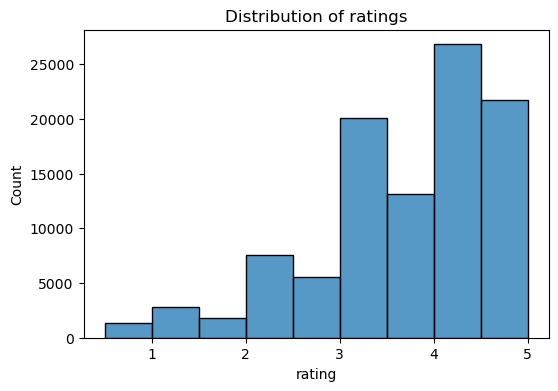

In [33]:
plt.figure(figsize=(6, 4))
plt.title('Distribution of ratings', fontsize = 12)
sns.histplot(data=dataset, x='rating', binwidth=0.5)
plt.show()

There are more higher than average ratings. 

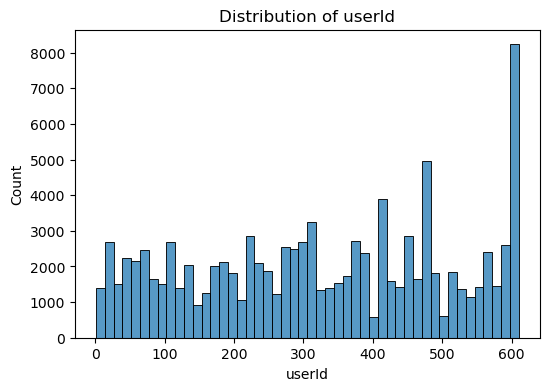

In [35]:
plt.figure(figsize=(6, 4))
plt.title('Distribution of userId', fontsize = 12)
sns.histplot(data=dataset, x='userId')
plt.show()

Users with higher sequence of user ID had given more ratings to the movies. 

---
## 4. <a id='section_4'>Cross Validation</a>

Cross Validation allows for comparing multiple models and selecting the one that performs best on average across different data folds. In this case, defualt of 5 fold is used. 

With k-fold cross validation, the dataset is divided into k equal-sized folds. The model is trained on k-1 folds and evaluated on the remaining fold. This process is repeated k times, with each fold used as the validation set once.

Singular Value Decomposition ([SVD](https://surprise.readthedocs.io/en/v1.1.4/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)) and non-negative matrix factorization ([NMF](https://surprise.readthedocs.io/en/v1.1.4/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF)) are Matrix Factorization based algorithms. 

KNN [basic](https://surprise.readthedocs.io/en/v1.1.4/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBasic) and KNN [baseline](https://surprise.readthedocs.io/en/v1.1.4/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline) are variation of KNN algorithms. 



In [38]:
# find the best model
kf = KFold(random_state=0) # folds will be the same for all algorithms, default = 5 

algos = (
    SVD(),
    NMF(),
    KNNBasic(),
    KNNBaseline(),
)

algo_dict = {
    'SVD': '{}'.format('SVD'),
    'NMF': '{}'.format('NMF'),
    'KNNBasic': '{}'.format('KNN Basic'),
    'KNNBaseline': '{}'.format('KNN Baseline'),
}

In [39]:
# create table of metrics

table = []
for algo in algos:
    start = time.time()
    out = cross_validate(algo, data, ['rmse', 'mae'], kf) # cross validate using full dataset
    cv_time = str(datetime.timedelta(seconds=int(time.time() - start))) # calculate time for validation
    model_name = algo_dict[algo.__class__.__name__]
    mean_rmse = '{:.3f}'.format(np.mean(out['test_rmse'])) # calculate mean of test_rmse
    mean_mae = '{:.3f}'.format(np.mean(out['test_mae'])) # calculate mean of test_mae
    new_line = [model_name, mean_rmse, mean_mae, cv_time]
    table.append(new_line) # append to list called table

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


Putting the metrics into a table below. 

In [41]:
# add header to the metrics information
metrics_df = pd.DataFrame(table, columns=['Model', 'RMSE', 'MAE', 'Run Time'])
# convert metrics to numeric
metrics_df['RMSE'] = pd.to_numeric(metrics_df['RMSE'])
metrics_df['MAE'] = pd.to_numeric(metrics_df['MAE'])
metrics_df

,Model,RMSE,MAE,Run Time
0,SVD,0.873,0.671,0:00:09
1,NMF,0.919,0.704,0:00:15
2,KNN Basic,0.947,0.726,0:00:08
3,KNN Baseline,0.875,0.668,0:00:11


The RMSE will always be larger or equal to the MAE. The greater difference between them, the greater the variance in the individual errors in the sample. 

Both the MAE and RMSE are negatively-oriented scores meaning the lower values are better.

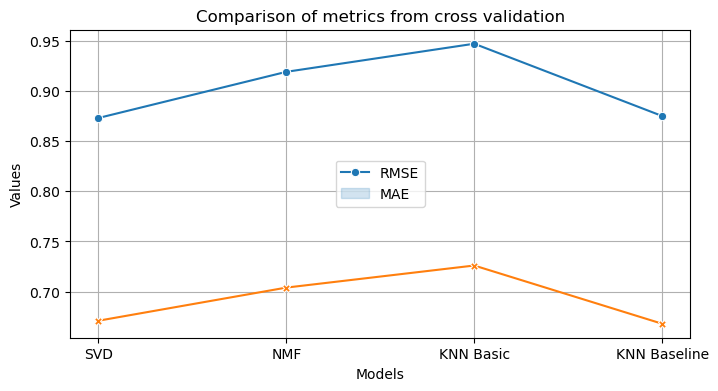

In [43]:
# plot RMSE and MAE for visualisation
plt.figure(figsize=(8, 4))
sns.lineplot(x='Model', y='RMSE', data=metrics_df, marker='o')
sns.lineplot(x='Model', y='MAE', data=metrics_df, marker='X')
plt.xlabel('Models')
plt.ylabel('Values')
plt.title('Comparison of metrics from cross validation')
plt.legend(['RMSE', 'MAE'], loc='center')
plt.grid(True)
plt.show()

SVD has produced better RMSE and MAE than the rest. 

---


## 5. <a id="section_5">Hyperparameters Tuning</a>

**SVD** extracts features and correlation from the user-item matrix. For example, when items are movies in different categories. **SVD** would generate factors when looking into the dimension space like action vs comedy, Hollywood vs Bollywood, or Marvel vs Disney.

**SVD** constructs a matrix with the row of users and columns of items and the elements are given by the users’ ratings. **SVD** decomposes a matrix into three other matrices and extracts the factors from the factorization of a high-level (user-item-rating) matrix.

Source: [TowardsDataScience](https://towardsdatascience.com/recommender-system-singular-value-decomposition-svd-truncated-svd-97096338f361#)


n_epochs – The number of iteration of the SGD procedure. Default is 20.

lr_all – The learning rate for all parameters. Default is 0.005.

reg_all – The regularization term for all parameters. Default is 0.02.


In [47]:
# search for best parameters
params = {'n_epochs': [5, 10, 20], 'lr_all': [0.002, 0.005, 0.008], 'reg_all': [0.2, 0.4, 0.6]}

gs = GridSearchCV(SVD, params, measures=['rmse', 'mae'], cv=10)
gs.fit(data)

In [48]:
# print the best parameters
results_df = pd.DataFrame.from_dict(gs.cv_results)
print(f"Best RMSE: {gs.best_score['rmse']}")
print(f"Best MAE: {gs.best_score['mae']}")
print(f"Best Parameters: {gs.best_params['rmse']}")

Best RMSE: 0.8689431318342009
Best MAE: 0.668642459959168
Best Parameters: {'n_epochs': 20, 'lr_all': 0.008, 'reg_all': 0.2}


## 6. <a id="section_6">Preparing for inference</a>

Since the best model is **SVD**, use this model to recommend movies for a user. 

**data.build_full_trainset()**: 

This method builds a recommendation dataset from all data, including the entire user and item rating data, so that you can train a model using all data.

**trainset.build_anti_testset()**: 

This method builds a dataset of user-item pairs that have not yet been rated. In other words, it is a dataset for making predictions for items that users have not yet rated. It is used by the recommendation engine to predict what ratings to give for items whose rating values ​​are unknown.

An anti-test set is a collection of items that a user has not rated. It's used to evaluate a recommendation system's ability to predict items a user might like based on their existing ratings.

In [52]:
# create train test sets
trainset = data.build_full_trainset()
testset = trainset.build_anti_testset()

In [53]:
# initiate model with suggest paramters
model = SVD(n_epochs = 20, lr_all = 0.008, reg_all = 0.2)

model.fit(trainset)
# estimate ratings for all userId-movieId pairs that are NOT in the training set
predictions = model.test(testset)

In [54]:
# define a function to extract top 10 movies recommendation for all users
def get_top_n(predictions, n=10): 
    top_n = defaultdict(list) # initialise empty dictionary to store user-item pairs
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est)) # append item ID and estiamted rating to top_n
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse= True) # sort the list of tuples by estimated rating in descending order
        top_n[uid] = user_ratings[:n] # keep the top n items for each user 
    return top_n

In [55]:
# prepare list of recommendations for each user ID
top_n = get_top_n(predictions, n=10)

In [56]:
# define a function to extract the list of recomendation for a user
def recommend_for_user(user_id):
    if user_id in top_n:
        if user_id in top_n:
            movie_ids = top_n[user_id][:10] # get top 10 for a given user
        else:
            movie_ids = []  # handle case where user ID is not found
        recommend_list = [item[0] for item in movie_ids]
        movie_titles = movies_df[movies_df['movieId'].isin(recommend_list)]['title'].tolist() # extract movie titles
        output_string = '' # create empty string to store final output
        output_string += '\n'.join(movie_titles) # # construct multi-line list of movies
        return output_string
    else:
        return 'No such user' # handle case where user ID is not found

In [57]:
# test if the inference works before passing to Gradio interface
user_id = int(input('Enter User ID: '))
recommend_for_user(user_id)

Enter User ID:  5


"Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)\nHis Girl Friday (1940)\nSecrets & Lies (1996)\nStreetcar Named Desire, A (1951)\nPaths of Glory (1957)\nRan (1985)\nTouch of Evil (1958)\nGuess Who's Coming to Dinner (1967)\nDay of the Doctor, The (2013)\nThree Billboards Outside Ebbing, Missouri (2017)"

## 7. <a id="section_7">Create Gradio interface</a>

In [59]:
interface = gr.Interface(
    fn = recommend_for_user,
    inputs = gr.Number(label='User ID'),
    outputs = gr.Text(label='Recomendations'),
    title = 'Movie Recommendation based on user',
    description = '\(^-^)/ Enter a user ID between 1 and 610. This model will recommend 10 movies for this user.'
)

# launch interface
if __name__ == '__main__':
    interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://1815cad2f5ecb6f6dc.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


---
## 8. <a id="section_8">Conclusion</a>

A **Collaborative Filtering** recommndation system for any products and services can be build using **Surprise** if data can be structured into user ID, item ID and rating. 

The advantages of using **Surprise** are the availability of tools to *evaluate, analyze and compare performance* of various *algorithms* in it's library. 

---